# Io AMI Image Deconvolution

In [43]:
import os
# os.chdir("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/amigo/src/amigo")

# autodiff
import jax
from jax import numpy as np
from zodiax.experimental import deserialise

# visualisation
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.transforms import Affine2D
import ehtplot
import scienceplots

# astronomy
import webbpsf

# optimisation
import optax

# AMIGO
import amigo
from amigo.optical_models import AMIOptics
from amigo.core_models import AmigoModel
from amigo.fitting import optimise
from amigo.files import get_files, summarise_files, get_Teffs, get_filters, initialise_params, get_exposures
from amigo.detector_models import LinearDetectorModel
from amigo.read_models import ReadModel
from amigo.ramp_models import SimpleRamp, PolyNonLin
from amigo.model_fits import PointFit
from amigo.fisher import calc_fishers
from amigo.plotting import plot, plot_losses, summarise_fit

# from amigo.stats import loss_fn

from io_funcs import initialise_disk, SimpleIoSource, ComplexIoSource, HD2236, niriss_parang, get_filter_spectrum
from io_funcs import io_model_fn
from plotting import get_extents, get_residuals, plotting_data_comparison, plot_params, plotting_io_comparison

from optim_funcs import sgd, adam, simple_norm_fn, complex_norm_fn, grad_fn, loss_fn
from optim_funcs import L1_loss, L2_loss, TV_loss, ME_loss, QV_loss
# files
from zodiax.experimental import serialise, deserialise

plt.style.use(['science', 'bright', 'no-latex'])

# matplotlib parameters
%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 8

inferno = colormaps["inferno"]
viridis = colormaps["viridis"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
viridis.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

jax.config.update("jax_enable_x64", True)

# Loading in Io Data
We have five Io exposures to load in, and four calibrator star exposures.

In [44]:
# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    # "/Users/mcha5804/JWST/ERS1373/calgrps/",
    "/Users/mcha5804/JWST/ERS1373/calslope_18/",
    "calslope",
    EXP_TYPE="NIS_AMI",
    FILTER=["F480M", "F430M", "F380M"],
    **kwargs
)

files = file_fn()

print(f"\n{len(files)}")
summarise_files(
    files,
    [
        # "ACT_ID",
        "TARGNAME",
        "APERNAME",
        "PUPIL",
        "SUBARRAY",
        "DETECTOR",
        "EXP_TYPE",
        "NINTS",
        "NGROUPS",
        "TGROUP",
        "OBSERVTN",
        "VISIT",
        "VISITGRP",
        "SEQ_ID",
        "ACT_ID",
        "EXPOSURE",
    ],
)


9
  TARGNAME: HD 2236, IO
  APERNAME: NIS_AMI1
  PUPIL: NRM
  SUBARRAY: SUB80
  DETECTOR: NIS
  EXP_TYPE: NIS_AMI
  NINTS: 8, 100
  NGROUPS: 18, 12
  TGROUP: 0.07544
  OBSERVTN: 023, 017
  VISIT: 001
  VISITGRP: 03, 04
  SEQ_ID: 1
  ACT_ID: 02
  EXPOSURE: 2, 3, 1, 5, 4


Here we can print out the shapes of the data, and we can see the calibrators have 12 groups and the Io exposures have 45 groups.

In [45]:
nsci = 1
sci_files = []

ncal = 4
cal_files = []

for file in files:
    if file[0].header["TARGPROP"] == "IO":
        sci_files.append(file)
    elif file[0].header["TARGPROP"] == "PSFCAL.2022A-HD2236-K6":
        file[0].header["TARGPROP"] = "HD 2236"
        cal_files.append(file)
    else:
        print(f"Unkown target: {file[0].header['TARGPROP']}")

sci_files = sci_files[:nsci]
cal_files = cal_files[4-ncal:]

for f in sci_files:
    print(f[0].header["TARGPROP"], f[0].header["NGROUPS"], f[1].data.shape)

for f in cal_files:
    print(f[0].header["TARGPROP"], f[0].header["NGROUPS"], f[1].data.shape)

# sci_files[0][0].header

IO 18 (17, 80, 80)
HD 2236 12 (11, 80, 80)
HD 2236 12 (11, 80, 80)
HD 2236 12 (11, 80, 80)
HD 2236 12 (11, 80, 80)


## Data visualisation
The calslops files (exposures) are of shape $(\text{ngroups - 1}, \text{npix}, \text{npix})$. Since we have up the ramp data, each exposure has $\text{ngroups}$ images, shown in the plot below. The title of the image is the peak pixel brightness of that image. The plot is simply the data from the first exposure. 

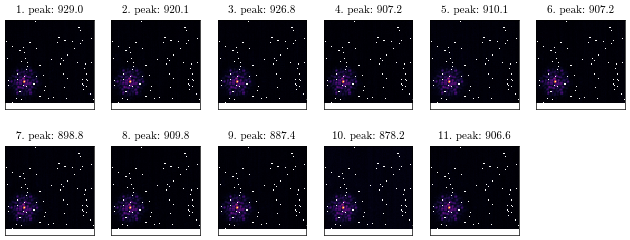

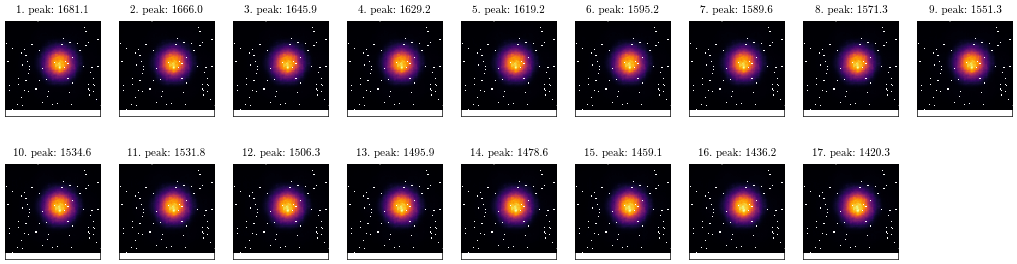

In [46]:
raw_data = np.asarray(cal_files[0][1].data, float)
# data = raw_data - raw_data[0]
cal_data = raw_data

plt.figure(figsize=(8, 3))
for i in range(cal_files[0][1].data.shape[0]):
    plt.subplot(2, 6, i + 1)
    plt.title(f"{i+1}. peak: {np.nanmax(cal_data[i]):.1f}", size=8)
    plt.imshow(cal_data[i])
    plt.xticks([])
    plt.yticks([])
    # plt.colorbar()
plt.show()


raw_data = np.asarray(sci_files[0][1].data, float)
# data = raw_data - raw_data[0]
data = raw_data

plt.figure(figsize=(13, 9))
for i in range(sci_files[0][1].data.shape[0]):
    plt.subplot(5, 9, i + 1)
    plt.title(f"{i+1}. peak: {np.nanmax(data[i]):.1f}", size=8)
    plt.imshow(data[i])
    plt.xticks([])
    plt.yticks([])
    # plt.colorbar()
plt.show()

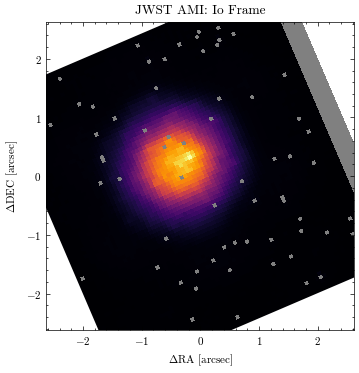

In [47]:
roll_angle = niriss_parang(sci_files[0][1].header)
niriss_pixel_scale = 0.0656  # arcsec/pixel

fig, ax = plt.subplots(figsize=(4, 4))
im = ax.imshow(data[0], **get_extents(data[0], niriss_pixel_scale), cmap=inferno)
trans_data = Affine2D().rotate_deg(-roll_angle) + ax.transData
im.set_transform(trans_data)
ax.set(
    title="JWST AMI: Io Frame",
    xlabel=r"$\Delta$RA [arcsec]",
    ylabel=r"$\Delta$DEC [arcsec]",
)
plt.show()

# Building the model
First I am going to build some custom source classes.

Now we finally build the models. Let's first load in the BFE and mask models.

In [48]:
saved_path = "/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/"
ramp_coeffs = np.load(saved_path + "ramp_coeffs.npy")
pupil_mask = deserialise(saved_path + "PolyBFE_AMI_mask.zdx")

# Get webbpsf optical system for OPD
inst = webbpsf.NIRISS()
inst.load_wss_opd_by_date(files[0][0].header["DATE-BEG"], verbose=False)
opd = np.array(inst.get_optical_system().planes[0].opd)

And now instantiate and initialise values for the model.

In [49]:
from amigo.model_fits import ModelFit
from jax.scipy.signal import convolve
from jax import Array
from amgio.model_fits import ResolvedFit, IoResolvedFit
from amgio.models import IoAmigoModel


In [50]:
### OPTICS
# Get dLux optical system
optics = AMIOptics(
    opd=opd,
    # pupil_mask=pupil_mask,
    normalise=True,
    )

### DETECTOR
# detector = LinearDetectorModel()
ramp_model = PolyNonLin().set("coeffs", ramp_coeffs)
# read_model = ReadModel()

# Setting up calibrator model
cal_fit = PointFit()
cal_exposures = get_exposures(cal_files, cal_fit)
cal_params = initialise_params(cal_exposures, optics)

cal_model = AmigoModel(
    cal_files,
    cal_params,
    optics=optics,
    ramp=ramp_model,
    )

# Setting up science model
sci_fit = IoResolvedFit()
sci_exposures = get_exposures(sci_files, sci_fit)
sci_params = initialise_params(sci_exposures, optics)

source_size = 100  # in oversampled pixels
ones = np.ones((source_size, source_size))
log_distribution = np.log10(ones / ones.sum())

log_distributions = {}
for exp in sci_exposures:
    dist_key = exp.get_key("log_distribution")
    log_distributions[dist_key] = log_distribution

sci_params["log_distribution"] = log_distributions

initial_sci_model = IoAmigoModel(
    sci_files,
    sci_params,
    source_coeffs=[1., 0.,],
    optics=optics,
    ramp=ramp_model,
    )


And finally let's define a model function since we are using the `BaseModeller`.

# Calibrator Fit

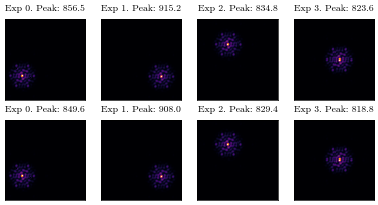

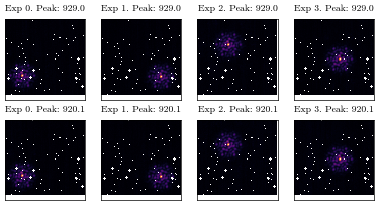

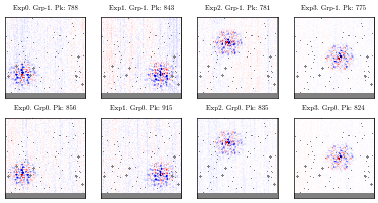

In [51]:
plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(cal_exposures):
    psf_ramp = cal_model.model(exp)
    for group_idx in range(2):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(psf_ramp[group_idx]):.1f}", size=7)
        plt.imshow(psf_ramp[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()

plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(cal_exposures):
    data = exp.slopes
    for group_idx in range(2):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(cal_data[group_idx]):.1f}", size=7)
        plt.imshow(data[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()

plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(cal_exposures):
    data = exp.slopes
    psf_ramp = cal_model.model(exp)
    for i, group_idx in enumerate(np.arange(-1, 1)):
        residuals, bounds = get_residuals(psf_ramp[group_idx], data[group_idx], return_bounds=True)
        plt.subplot(4, 5, exp_idx + 5 * i + 1)
        plt.title(f"Exp{exp_idx}. Grp{group_idx}. Pk: {np.nanmax(psf_ramp[group_idx]):.0f}", size=5)
        plt.imshow(residuals, **bounds)
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()


## Optimisation

In [52]:
cal_params = [
    "positions",
    "aberrations",
    # "reflectivity",
    "fluxes",
    # "one_on_fs",
    # "rotation",
    # "compression",
    # "shear",
    # "translation",
    # "f2f",
    # "holes",
    # "dark_current",
    # "distance",
    # "jitter.r",
    # "jitter.shear",
    # "jitter.phi",
    # "ramp.coeffs",
    # "anisotropy.compression",
    # "dispersion",
    # "SRF",
    # "ipc",
    # "FF",
    # "defocus",
]
rampless_model = cal_model.set("ramp", None)
cal_fishers = calc_fishers(rampless_model, cal_exposures, cal_params)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

2024-07-23 12:49:24.808285: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce-window = f64[9,32,32]{2,1,0} reduce-window(f64[9,1024,1024]{2,1,0} %constant.2590, f64[] %constant.174), window={size=1x32x32 stride=1x32x32}, to_apply=%region_1.101

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-07-23 12:49:25.218072: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.411188s
Constant folding an instruction is taking > 1s:

  %reduce-window = f64[9,32,32]{2,1,0} reduce-window(f64[9,1024,1024]{2,1,0} %constant.2590, f64[] %constant.174), window={size=1

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [53]:
n_epoch = 30

config = {
    "positions": sgd(5e-1, 0),
    "fluxes": sgd(9e-2, 3),
    "aberrations": sgd(5e-2, 6),
    # "one_on_fs": sgd(1e-1, 9),
}

cal_final_model, cal_losses, cal_histories, cal_states = optimise(
    cal_model,
    cal_exposures,
    fishers=cal_fishers,
    optimisers=config,
    epochs=n_epoch,
    # grad_fn=grad_fn,
    print_grads=False,
)

  0%|          | 0/30 [00:00<?, ?it/s]

Grad Batch fn compiling...
Compiling update function
Grad Batch fn compiling...
Grad Batch fn compiling...
Grad Batch fn compiling...
Compiling update function
Compile Time: 0:00:44
Initial Loss: 70.87
Est time per epoch:  0:00:22
Est run remaining:  0:11:49
Full Time: 0:11:36
Final Loss: 32.01


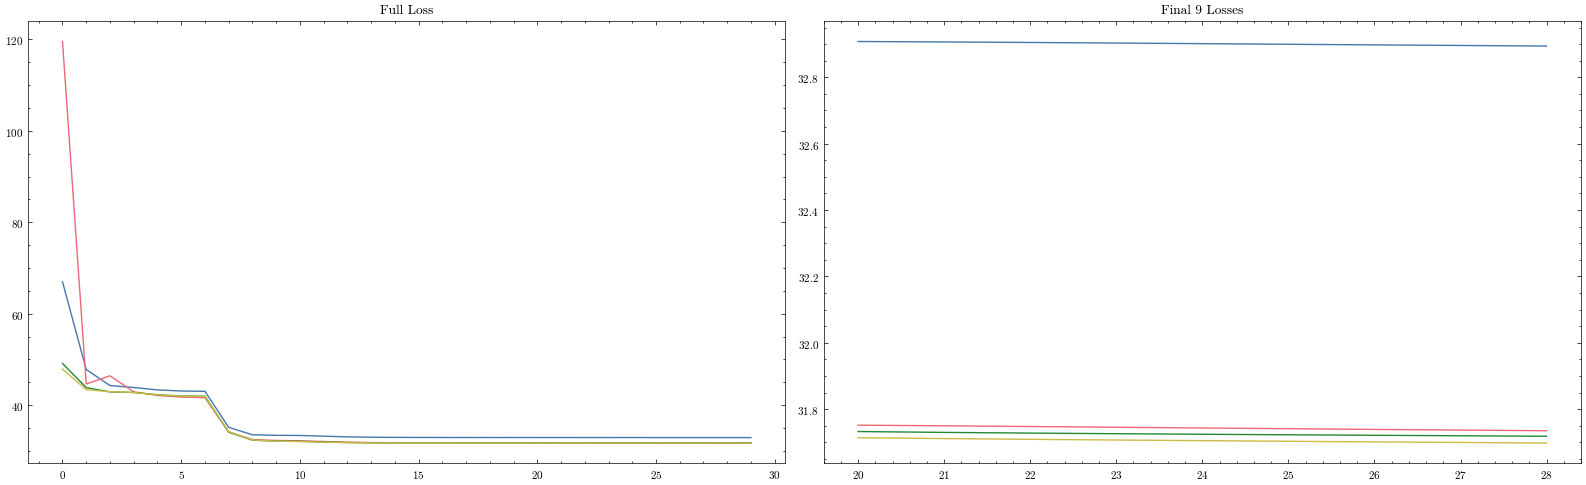

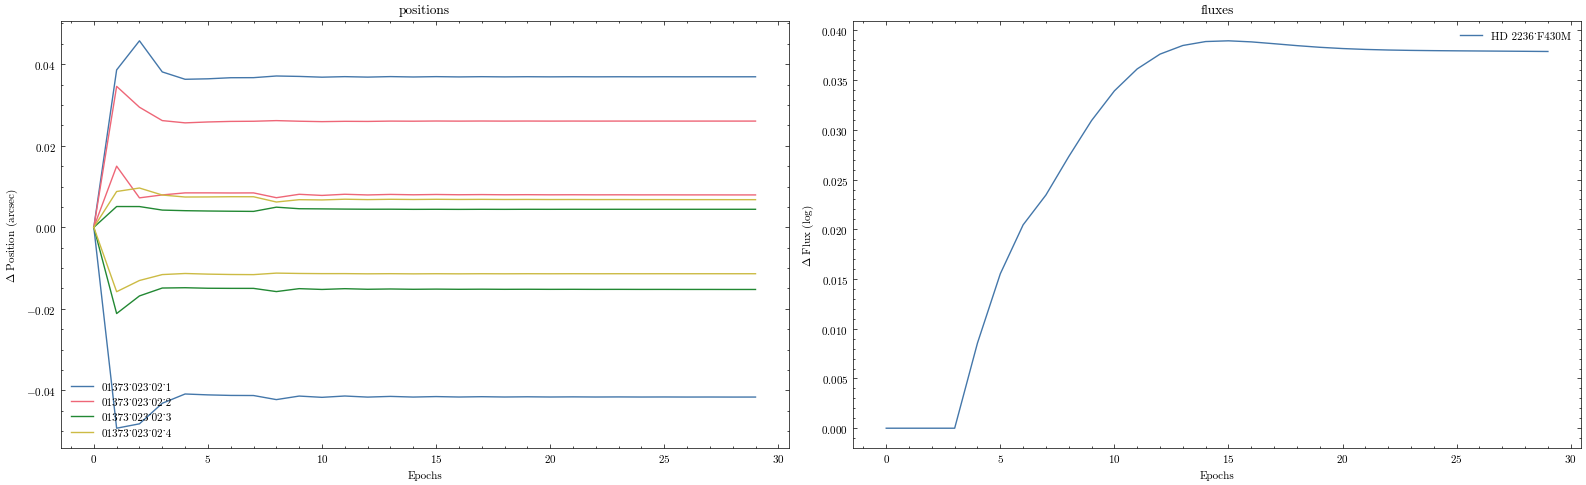

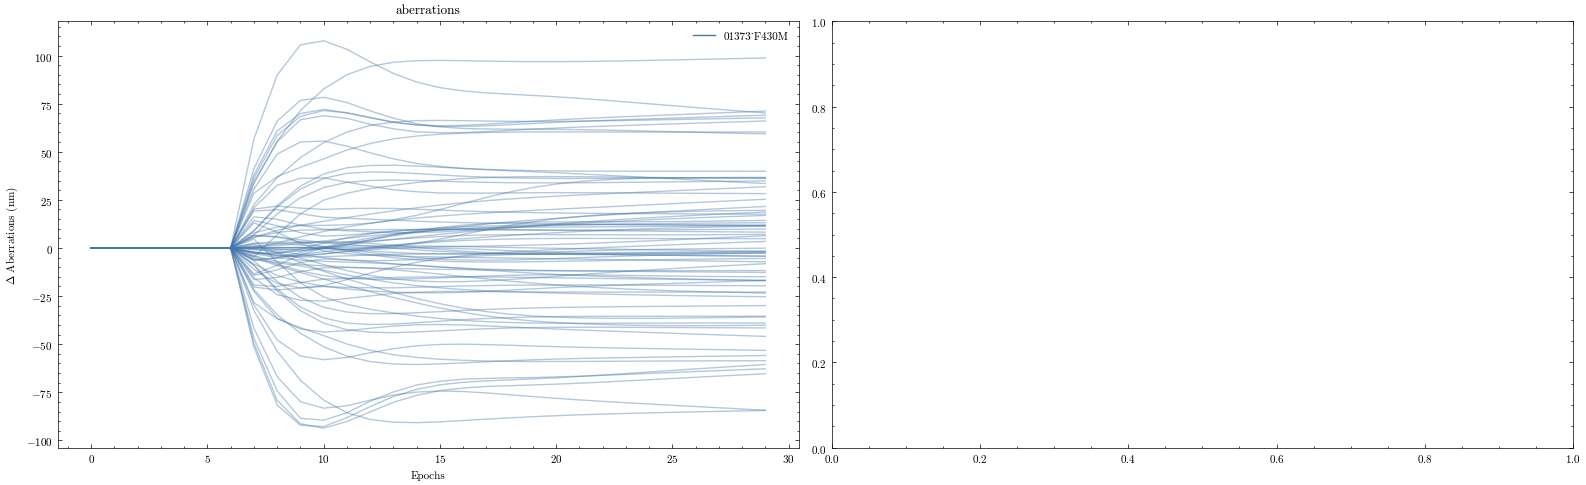

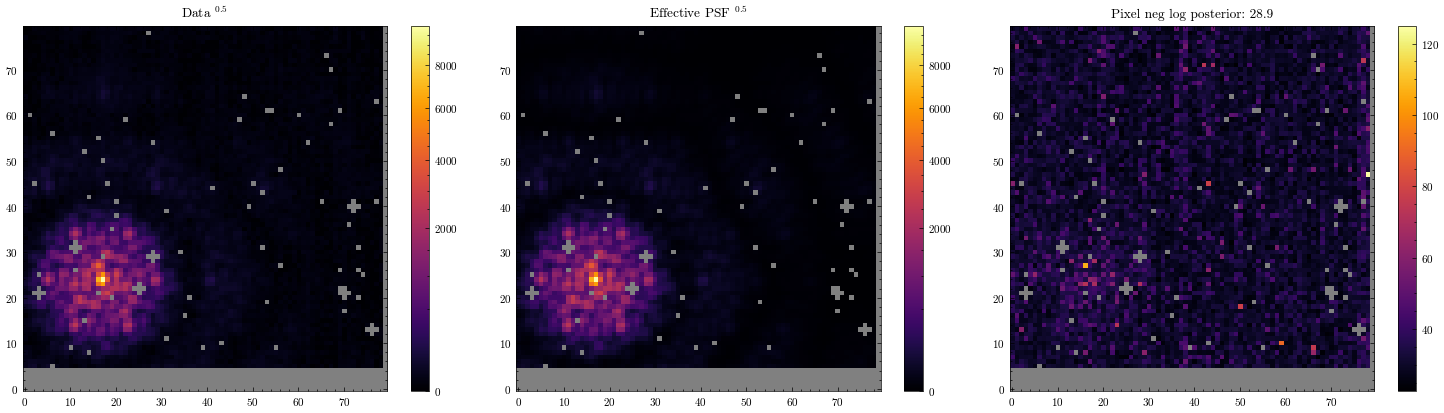

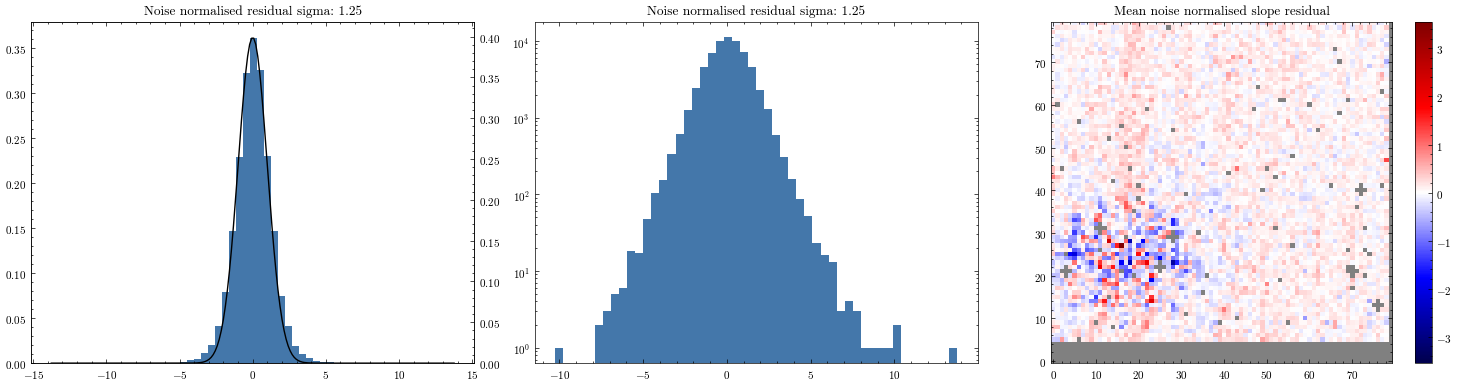

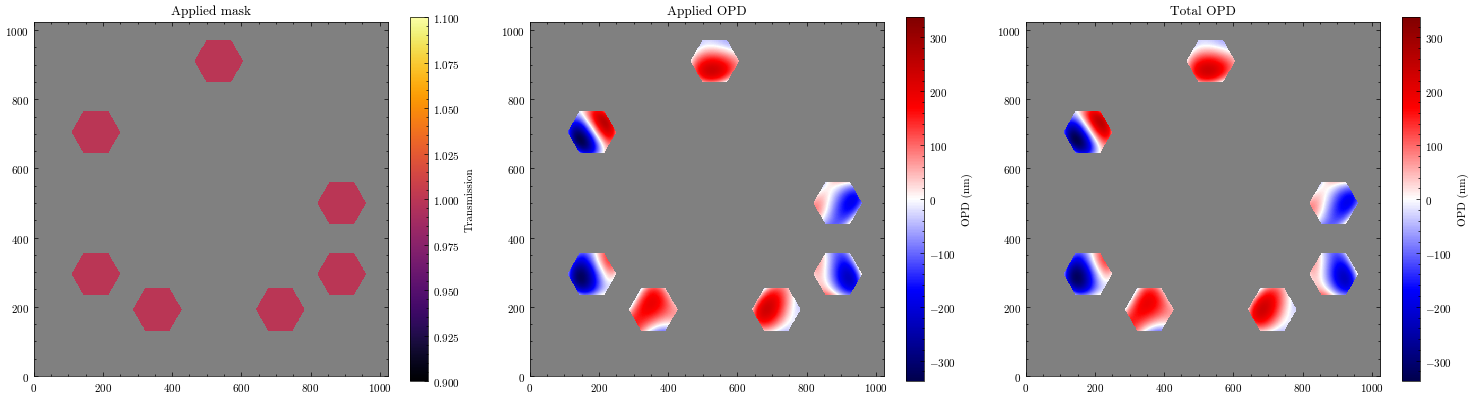

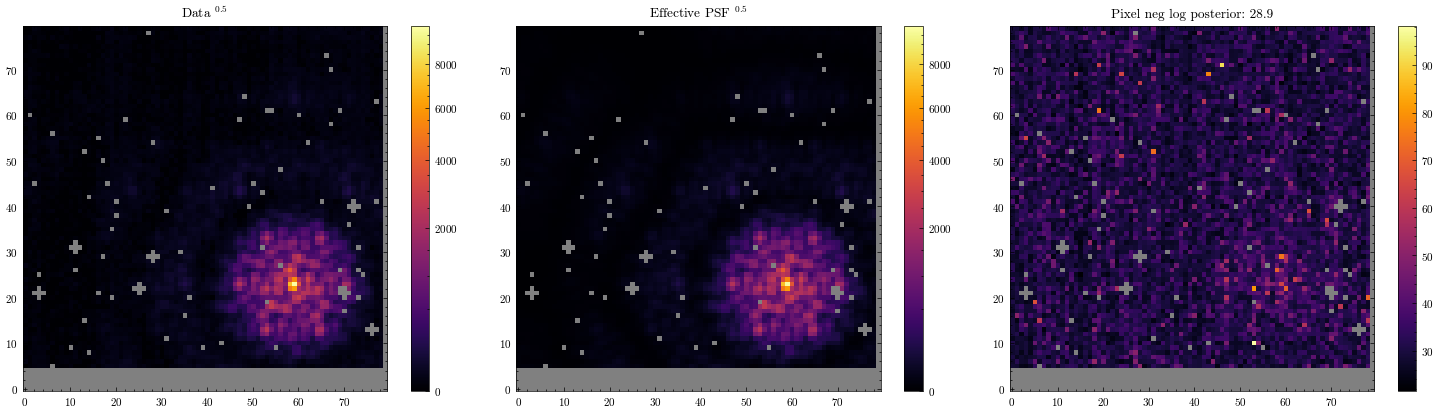

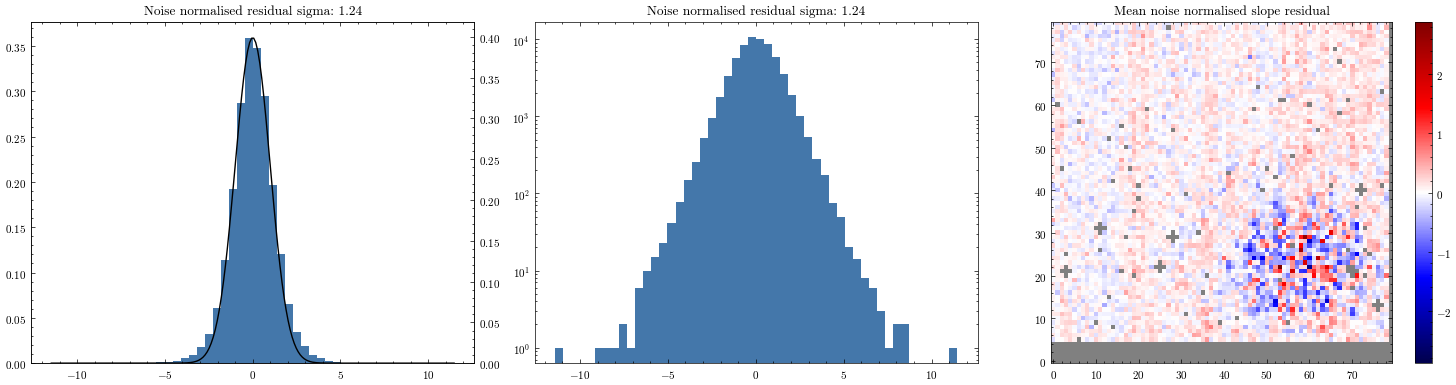

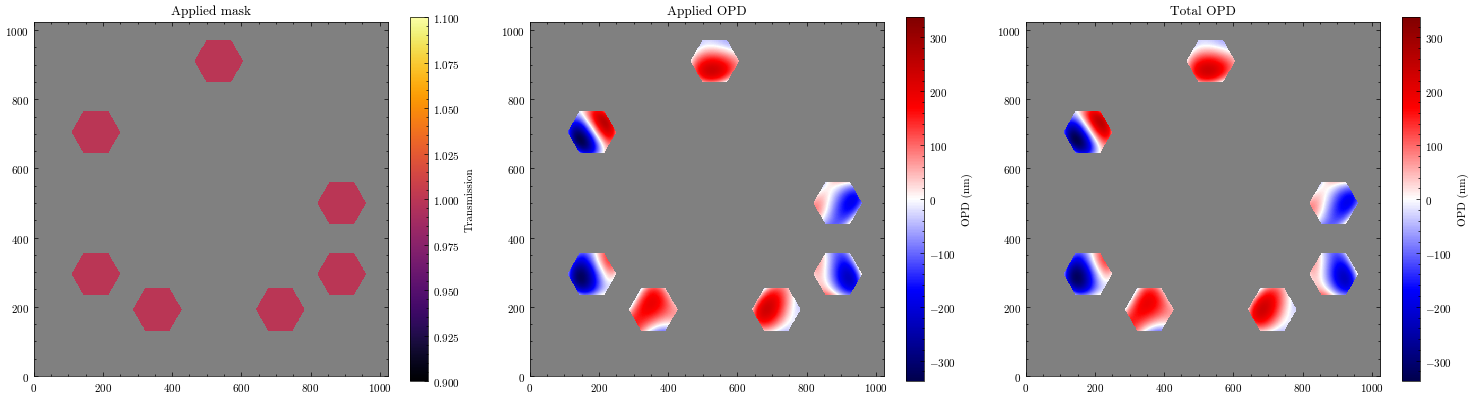

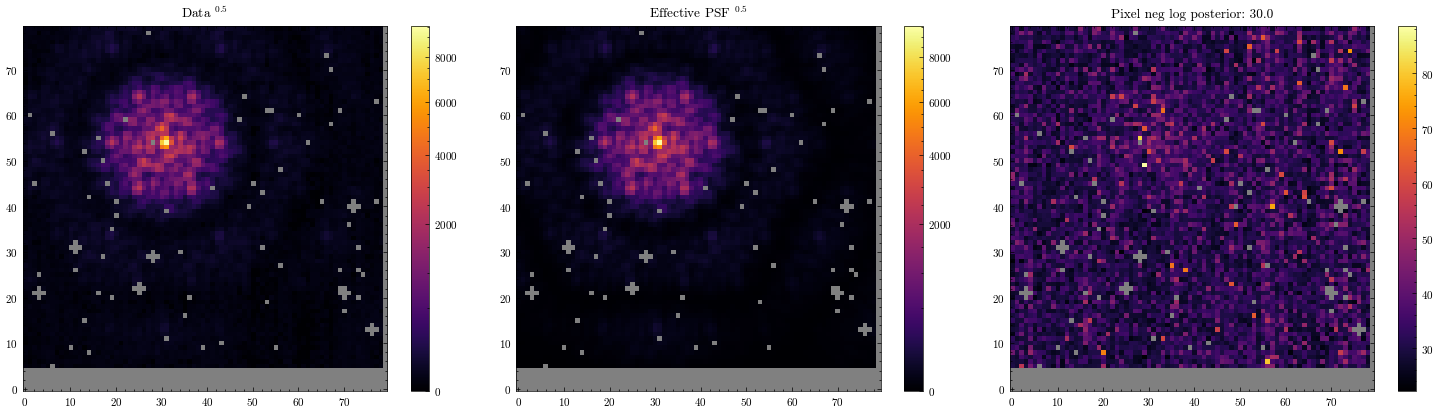

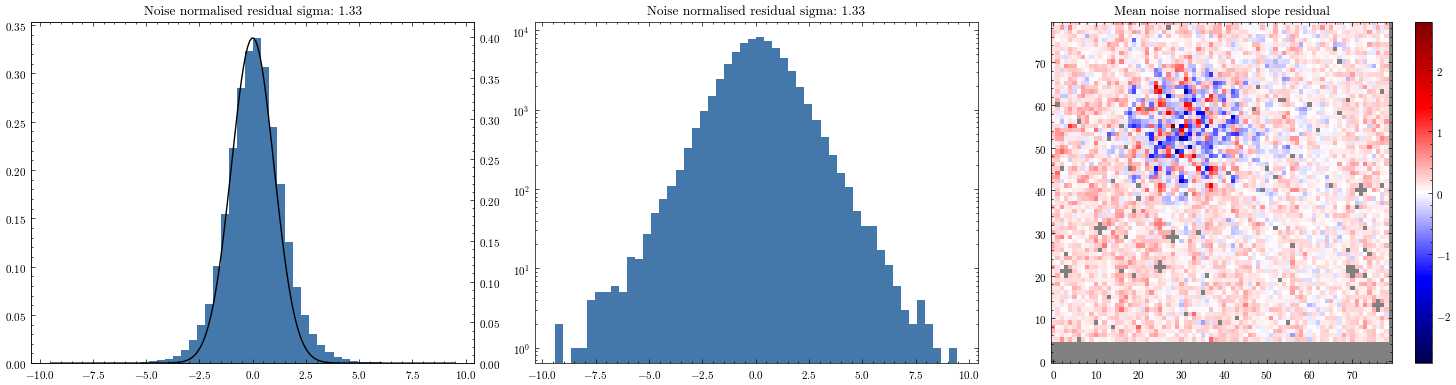

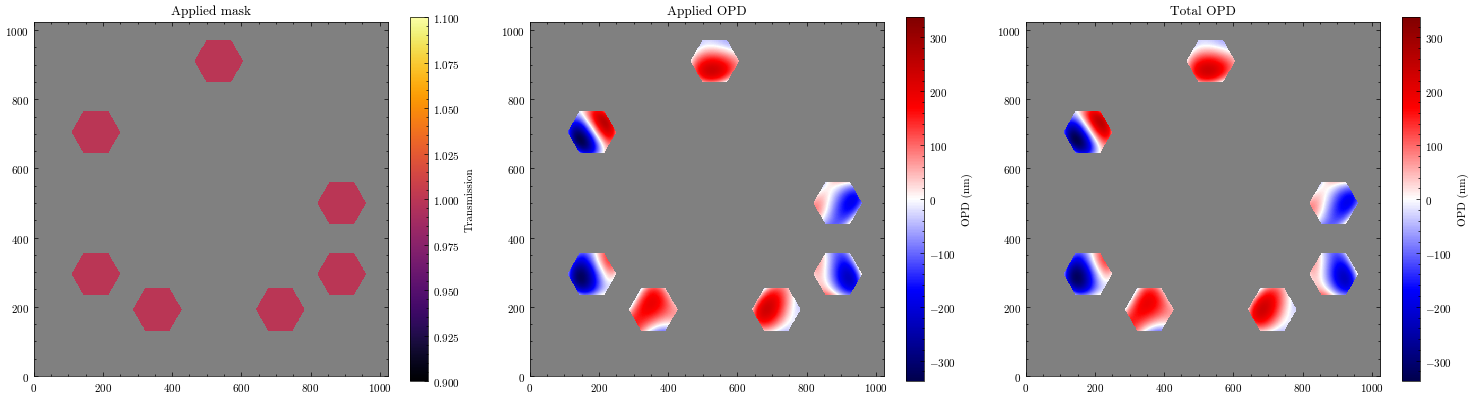

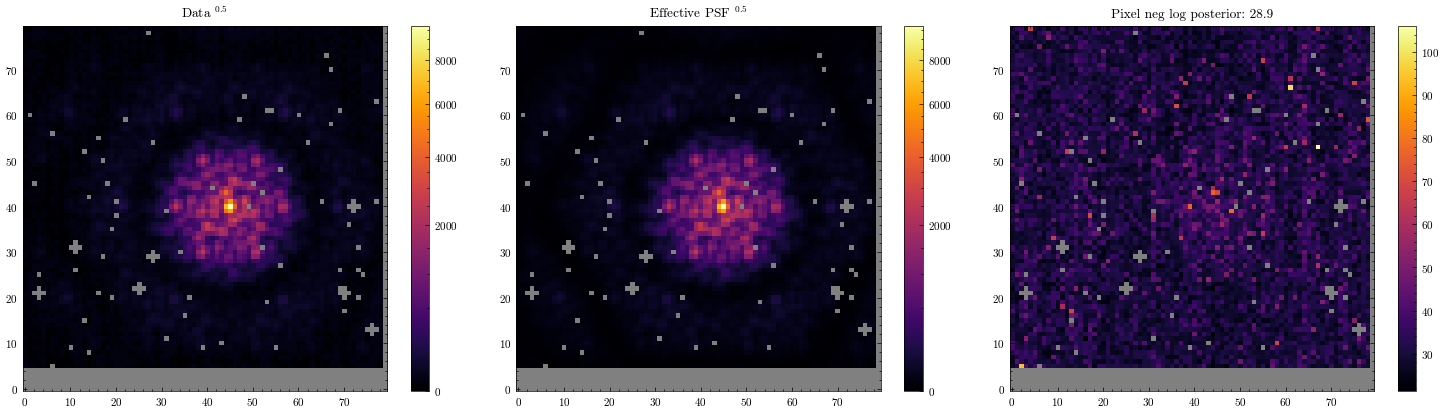

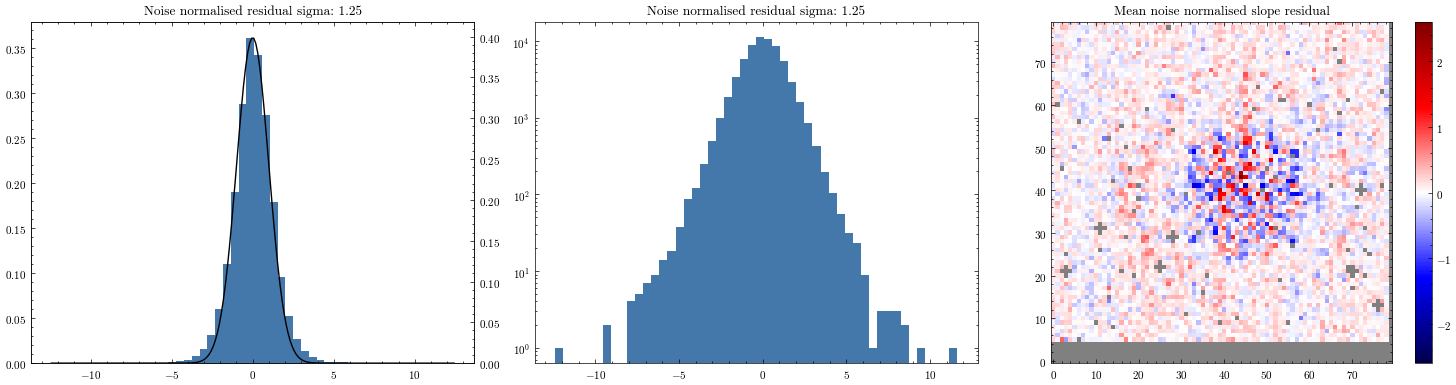

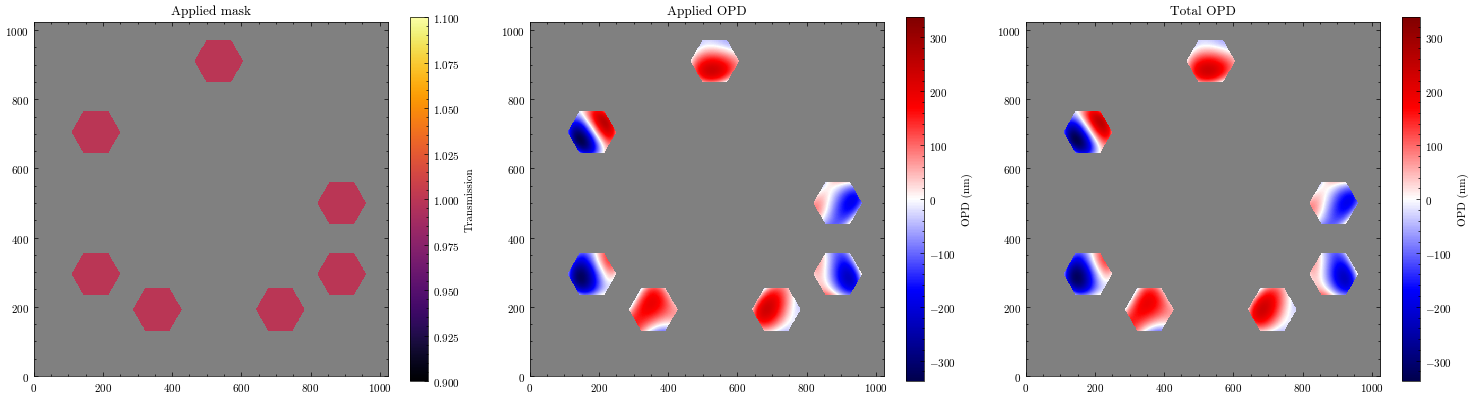

In [54]:
plot_losses(cal_losses, start=20)
for history in cal_histories:
    plot(history)

for exp in cal_exposures:
    # exp.print_summary()
    summarise_fit(
        exp,
        cal_final_model,
        # test_model,
        residuals=True,
        histograms=True,
        # flat_field=True,
        # up_the_ramp=True,
        # up_the_ramp_norm=True,
        # full_bias=True,
        aberrations=True,
    )

Saving the aberrations...

In [55]:
# serialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/aberrations.zdx", cal_final_model.aberrations)
# np.save("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/BFE_linear.npy", cal_final_model.BFE.linear)
# np.save("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/BFE_quadratic.npy", cal_final_model.BFE.quadratic)


# Io

First, let's set the abberations of our Io model to be what we recovered from the calibrator.

In [18]:
ab_dict = deserialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/aberrations.zdx")

# Setting io aberrations to those recovered from calibrator
sci_model = initial_sci_model.set("aberrations", ab_dict)

## Visualisation

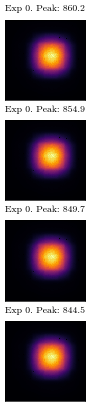

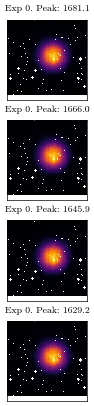

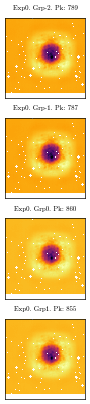

In [19]:
plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(sci_exposures):
    psf_ramp = sci_model.model(exp)
    for group_idx in range(4):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(psf_ramp[group_idx]):.1f}", size=7)
        plt.imshow(psf_ramp[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()


plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(sci_exposures):
    data = exp.slopes
    for group_idx in range(4):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(data[group_idx]):.1f}", size=7)
        plt.imshow(data[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()

plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(sci_exposures):
    data = exp.slopes
    psf_ramp = sci_model.model(exp)
    for i, group_idx in enumerate(np.arange(-2, 2)):
        plt.subplot(4, 5, exp_idx + 5 * i + 1)
        plt.title(f"Exp{exp_idx}. Grp{group_idx}. Pk: {np.nanmax(psf_ramp[group_idx]):.0f}", size=5)
        plt.imshow(psf_ramp[group_idx] - data[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()


# Optimisation

In [20]:
sci_params = [
    "positions",
    # "aberrations",
    "fluxes",
    # "one_on_fs",
    "log_distribution",
    "source_spectrum.coefficients"
]
rampless_model = sci_model.set("ramp", None)
sci_fishers = calc_fishers(rampless_model, sci_exposures, sci_params)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [28]:
from amigo.stats import posterior

def L1_loss(model):
    # only applied to the volcano array
    return np.nansum(model.source.volc_frac * np.abs(10**model.source.log_volcanoes))


def L2_loss(model, exposure):
    # TODO BRUH THIS NORMALISED
    distribution = model.distribution(exposure)
    return np.nansum((distribution - distribution.mean())**2)


def TV_loss(model, exposure):
    array = np.pad(model.distribution(exposure), 2)
    diff_y = np.abs(array[1:, :] - array[:-1, :]).sum()
    diff_x = np.abs(array[:, 1:] - array[:, :-1]).sum()
    # return np.hypot(diff_x, diff_y)
    return diff_x + diff_y


def QV_loss(model, exposure):
    array = np.pad(model.distribution(exposure), 2)
    diff_y = np.square(array[1:, :] - array[:-1, :]).sum()
    diff_x = np.square(array[:, 1:] - array[:, :-1]).sum()
    return diff_x + diff_y


def ME_loss(model, exposure, eps=1e-16):
    """
    Maximum Entropy loss function.
    """
    P = model.distribution(exposure) / np.nansum(model.distribution(exposure))
    S = np.nansum(-P * np.log(P + eps))
    return -S

reg_func_dict = {
    "L1": L1_loss,
    "L2": L2_loss,
    "TV": TV_loss,
    "QV": QV_loss,
    "ME": ME_loss,
}

def loss_fn(model, exposure, args={}):
    loss = -np.array(posterior(model, exposure, per_pix=True)).sum()

    # regularisation
    for reg in args["reg_dict"].keys():
        coefficient = args["reg_dict"][reg]
        reg_function = args["reg_func_dict"][reg]
        loss += coefficient * reg_function(model, exposure)

    return loss

In [37]:
n_epoch = 30

reg_dict = {
    # "L1": 1.e0,
    # "L2": 1.e1,
    "TV": 2.e1,
    # "QV": 3.e1,
    # "ME": 2e1, 
}

args = {
    "reg_dict": reg_dict,
    "reg_func_dict": reg_func_dict,
    }

config = {
    "positions": sgd(3e-1, 0),
    "fluxes": sgd(2e-1, 3),
    "log_distribution": adam(2e-1, 4, (10, 0.25), b1=0.7),
    "source_spectrum.coefficients": sgd(1e-1, 5),
    # "one_on_fs": sgd(1e-1, 9),
}

sci_final_model, sci_losses, sci_histories, sci_states = optimise(
    sci_model,
    sci_exposures,
    optimisers=config,
    fishers=sci_fishers,
    loss_fn=loss_fn,
    args=args,
    epochs=n_epoch,
    # grad_fn=grad_fn,
    print_grads=False,
)

  0%|          | 0/30 [00:00<?, ?it/s]

Grad Batch fn compiling...
Compiling update function
Compiling update function
Compile Time: 0:00:14
Initial Loss: 14,668.22
Est time per epoch:  0:00:09
Est run remaining:  0:04:55
Full Time: 0:04:39
Final Loss: 105.64


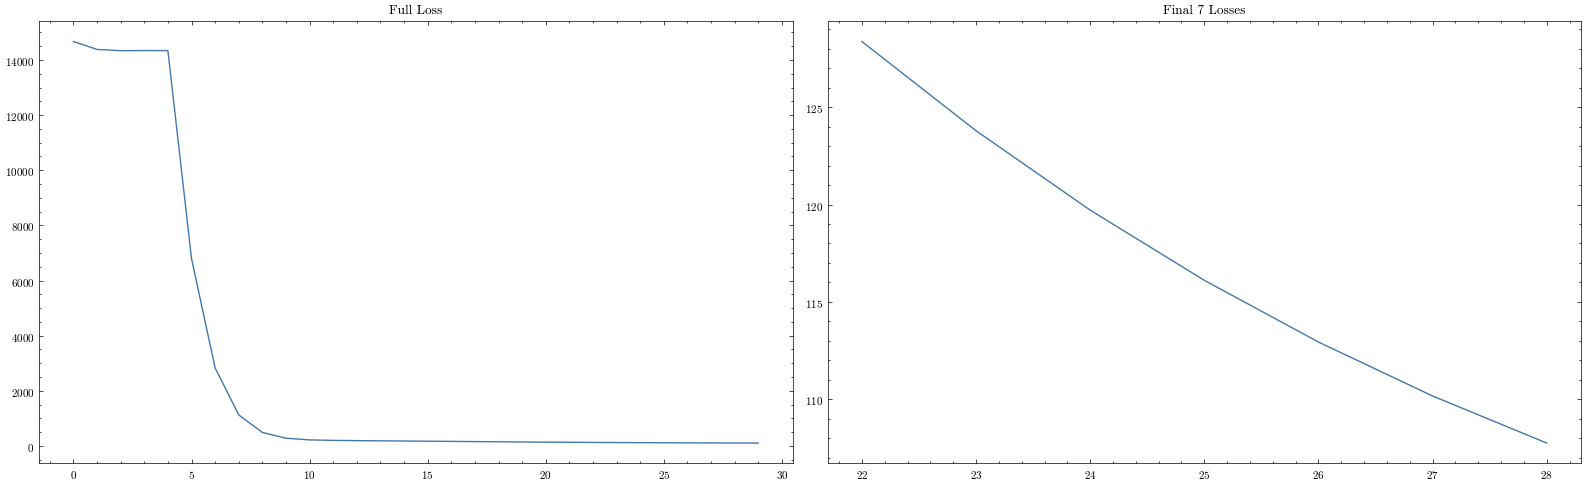

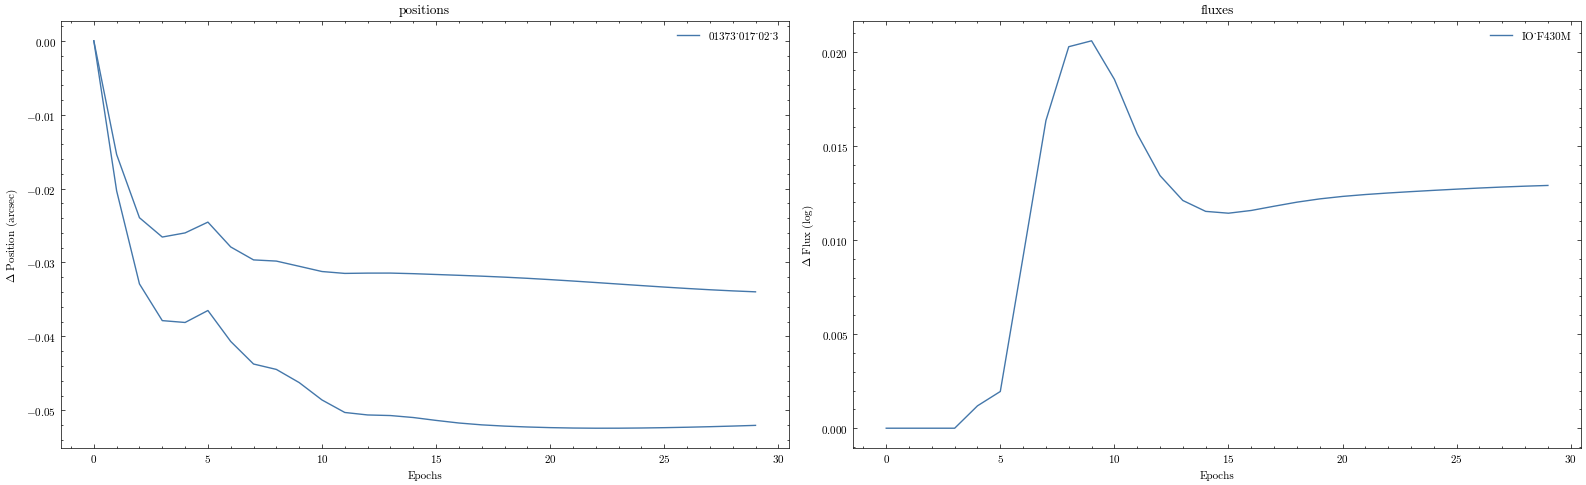

No formatting function for log_distribution
No formatting function for source_spectrum.coefficients


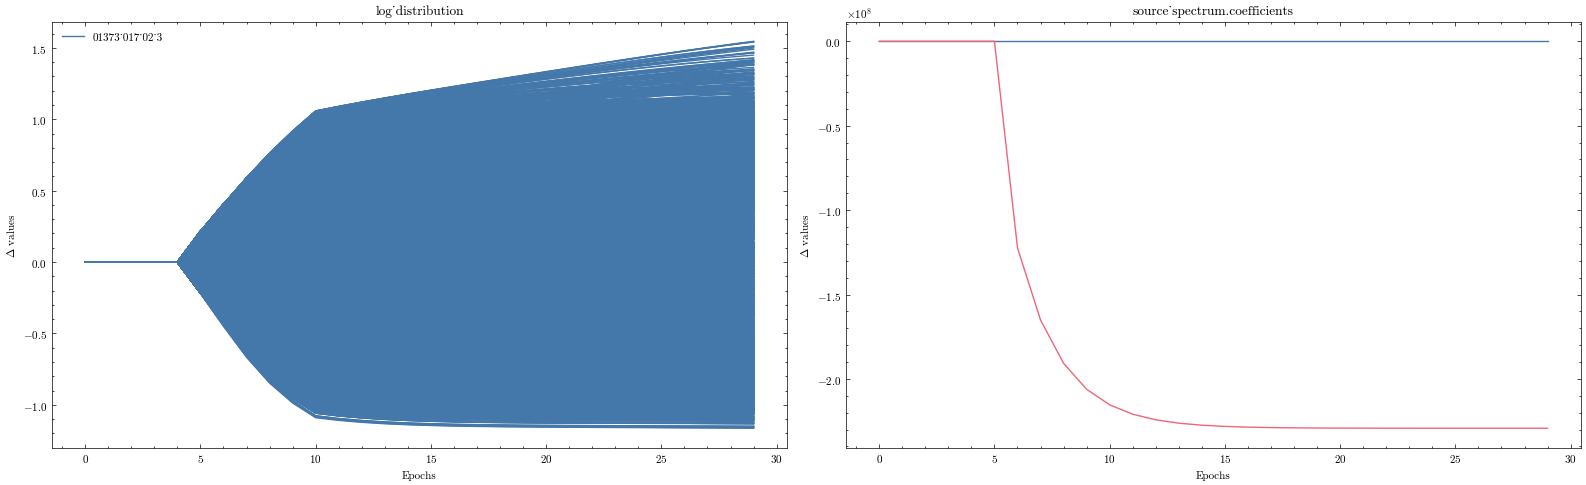

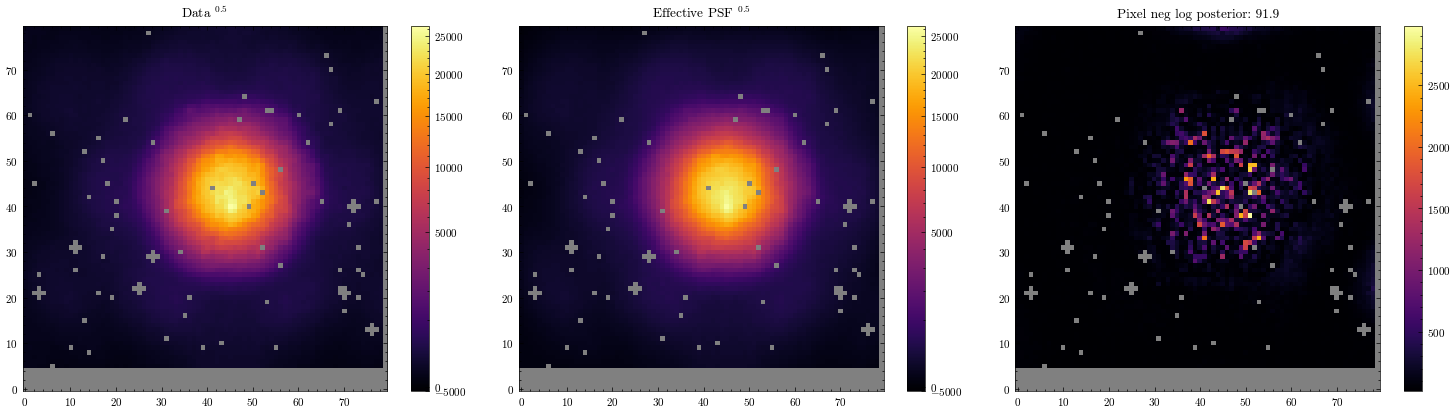

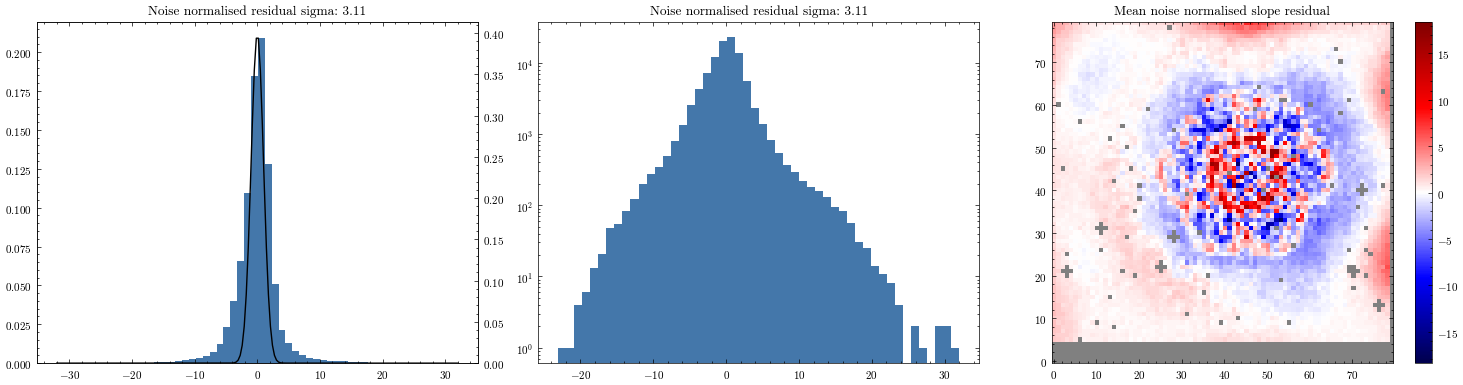

In [38]:
plot_losses(sci_losses, start=int(n_epoch*0.75))
plot(sci_histories[0])

for exp in sci_exposures:
    # exp.print_summary()
    summarise_fit(
        exp,
        sci_final_model,
        # test_model,
        residuals=True,
        histograms=True,
        # flat_field=True,
        # up_the_ramp=True,
        # up_the_ramp_norm=True,
        # full_bias=True,
        # aberrations=True,
    )

In [39]:
from plotting import plot_ephemeris, plot_diffraction_limit, get_arcsec_extents, plot_io_with_ephemeris, io_on_that_day
from matplotlib.colors import PowerNorm
from dLux import utils as dlu

def plotting_io_comparison(
    model,
    initial_distribution,
    save: str = None,
    roll_angle_degrees=0.0,
    cmap="afmhot_u",
    eph_cmap="gist_gray",
    io_max=None,
    power=0.5,
    eph_power=1.,
):
    fin_dist = 10 ** model.log_distribution

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

    # Plot initial distribution
    im0 = plot_io(
        axs[0],
        initial_distribution,
        roll_angle_degrees=roll_angle_degrees,
        model=model,
        vmax=io_max,
        cmap=cmap,
        power=power,
    )
    fig.colorbar(im0, ax=axs[0], label="flux")
    axs[0].set_title("Initial Distribution")

    im1 = plot_io(
        axs[1],
        fin_dist,
        roll_angle_degrees=roll_angle_degrees,
        model=model,
        vmax=io_max,
        cmap=cmap,
        power=power,
    )

    fig.colorbar(im1, ax=axs[1], label="flux")
    axs[1].set_title("Io Recovered Distribution")

    # Plot initial distribution
    plot_ephemeris(
        axs[2],
    )
    im2 = plot_io(
        axs[2],
        fin_dist,
        roll_angle_degrees=roll_angle_degrees,
        model=model,
        vmax=io_max,
        cmap=eph_cmap,
        power=eph_power,
    )
    fig.colorbar(im2, ax=axs[2], label="flux")
    axs[2].set_title("With Ephemeris")

    plt.tight_layout()
    if save is not None:
        plt.savefig(f"{save}result.pdf")
        plt.close()
    else:
        plt.show()

def plot_io(
    ax,
    array,
    roll_angle_degrees: float = 0.0,
    pixel_scale: float = 0.0656 / 4,
    model=None,
    show_diff_lim: bool = True,
    cmap: str = "afmhot_10u",
    bg_color: str = "k",
    axis_labels: dict = {
        "xlabel": r"$\Delta$RA [arcsec]",
        "ylabel": r"$\Delta$DEC [arcsec]",
    },
    vmin: float = 0.0,
    vmax: float = None,
    power=0.5,
):
    rotation_transform = Affine2D().rotate_deg(
        roll_angle_degrees
    )  # Create a rotation transformation

    ax.set_facecolor(bg_color)  # Set the background colour to black
    ax.set(**axis_labels)  # Set the axis labels
    if model is not None:
        pixel_scale = model.psf_pixel_scale / model.optics.oversample
        if show_diff_lim:
            ax = plot_diffraction_limit(model, ax, OOP=True)
    im = ax.imshow(
        array,
        cmap=cmap,
        extent=get_arcsec_extents(pixel_scale, array.shape),
        norm=PowerNorm(power, vmin=vmin, vmax=vmax),
    )

    trans_data = rotation_transform + ax.transData  # creating transformation
    im.set_transform(trans_data)  # applying transformation to image

    return im

def plot_diffraction_limit(model, ax=None, OOP=False):
    wavels = model.filters["F430M"][0]
    diff_lim = dlu.rad2arcsec(wavels.mean() / model.optics.diameter)
    scale_length = diff_lim

    scale_bar_x = -0.55
    scale_bar_y = -0.55

    if OOP and ax is not None:
        ax.plot(
            [scale_bar_x, scale_bar_x + scale_length],
            [scale_bar_y, scale_bar_y],
            color="hotpink",
            linewidth=2,
        )
        ax.text(
            scale_bar_x + scale_length / 2 - 0.046,
            scale_bar_y + 0.02,
            r"$\lambda / D$",
            color="hotpink",
            fontsize=8,
        )
        return ax

    else:
        plt.plot(
            [scale_bar_x, scale_bar_x + scale_length],
            [scale_bar_y, scale_bar_y],
            color="hotpink",
            linewidth=2,
        )
        plt.text(
            scale_bar_x + scale_length / 2 - 0.046,
            scale_bar_y + 0.02,
            r"$\lambda / D$",
            color="hotpink",
            fontsize=8,
        )

def plot_io_with_ephemeris(
    
    ax, array, roll_angle_degrees=246.80584209034947, legend=False, n_volc=10, date="2022-08-01T16:52:00.000", **kwargs
):
    body = io_on_that_day(n_volc=n_volc, date=date)

    plot_io(ax, array, roll_angle_degrees, show_diff_lim=True, **kwargs)

    body.plot_wireframe_angular(
        ax,
        add_title=False,
        label_poles=True,
        indicate_equator=True,
        indicate_prime_meridian=False,
        grid_interval=15,
        grid_lat_limit=75,
        aspect_adjustable="box",
        formatting={
            "limb": {
                "linestyle": "--",
                "linewidth": 0.8,
                "alpha": 0.8,
                "color": "white",
            },
            "grid": {
                "linestyle": "--",
                "linewidth": 0.5,
                "alpha": 0.8,
                "color": "white",
            },
            "equator": {"linewidth": 1, "color": "r", "label": "equator"},
            "terminator": {
                "linewidth": 1,
                "linestyle": "-",
                "color": "aqua",
                "alpha": 0.7,
                "label": "terminator",
            },
            "coordinate_of_interest_lonlat": {
                "color": "g",
                "marker": "^",
                "s": 50,
                "label": "volcano",
            },
            # 'limb_illuminated': {'color': 'b'},
        },
    )

    if legend:
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(
            by_label.values(),
            by_label.keys(),
            loc="upper left",
        )

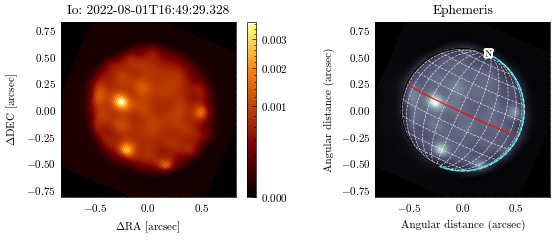

In [40]:
# plotting_io_comparison(
#     sci_final_model,
#     initial_distribution=10**initial_sci_model.log_distribution,
#     # roll_angle_degrees=roll_angle,
#     save=None,
#     cmap="afmhot_u",
#     eph_cmap="bone_ur",
#     io_max=(10 ** sci_final_model.log_distribution).max(),
#     power=0.8,
#     eph_power=1.,
# )

io_peak_flux = np.array(
        [10 ** sci_final_model.log_distribution[exp.key] for exp in sci_exposures]
    ).max()

save_dir = "gifs/spinning_io/"
for exp, file in zip(sci_exposures, sci_files):

    time = file[0].header["DATE-BEG"]

    # plt.figure(figsize=(7,5))
    # plt.title(f'Recovered Distribution: {time}')
    # plt.imshow(
    #     10 ** sci_final_model.log_distribution[exp.key],
    #     cmap='afmhot_10u',
    #     interpolation="none",
    #     vmax=0.0045,
    #     )
    # plt.colorbar()
    # # plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(6, 2.5))
    c0 = plot_io(
        ax[0],
        10 ** sci_final_model.log_distribution[exp.key],
        roll_angle_degrees=roll_angle,
        cmap="afmhot_u",
        vmax=io_peak_flux,
        )
    c1 = plot_io_with_ephemeris(
        ax[1],
        10 ** sci_final_model.log_distribution[exp.key],
        roll_angle_degrees=roll_angle,
        n_volc=0,
        cmap="bone_u",
        date=time,
        vmax=io_peak_flux,
    )

    fig.colorbar(c0)
    ax[0].set_title(f"Io: {time}")
    ax[1].set_title(f"Ephemeris")
    plt.tight_layout()
    # plt.savefig(save_dir + f"{time}.png", dpi=300)
    # plt.close()
    plt.show()



In [33]:
sci_final_model.source_spectrum.coefficients

Array([ 9.95585416e-01, -2.29199950e+08], dtype=float64)

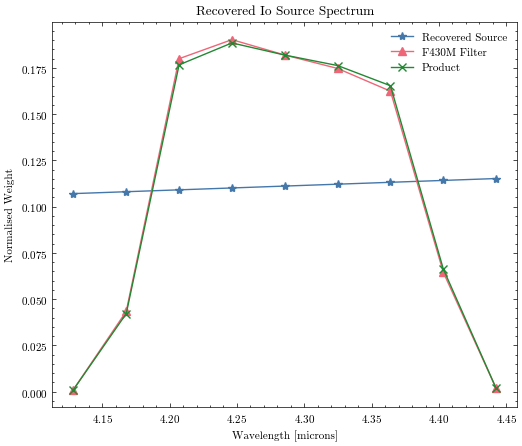

In [34]:
wavels = sci_final_model.source_spectrum.wavelengths
recovered_source = sci_final_model.source_spectrum.weights
f430m = sci_final_model.filters["F430M"][1]
product = f430m * recovered_source
product /= product.sum()
plt.figure(figsize=(6, 5))
plt.plot(10**6 * wavels, recovered_source, label="Recovered Source", marker='*')
plt.plot(10**6 * wavels, f430m, label="F430M Filter", marker="^")
plt.plot(10**6 * wavels, product, label="Product", marker="x")
plt.title("Recovered Io Source Spectrum")
plt.xlabel("Wavelength [microns]")
plt.ylabel("Normalised Weight")
plt.legend()
plt.show()

In [35]:
filter_eff = np.dot(f430m, wavels)
recovered_eff = np.dot(product, wavels)

print(f"Effective wavel before: {10**6 * filter_eff:.4f} microns")
print(f"Effective wavel after: {10**6 * recovered_eff:.4f} microns")

percentage_shift = 100 * (recovered_eff - filter_eff) / filter_eff
print(f"Percentage shift: {percentage_shift:.3f}%")

Effective wavel before: 4.2861 microns
Effective wavel after: 4.2871 microns
Percentage shift: 0.023%


In [ ]:
import os
from PIL import Image

# Create and save a gif using the images in "save_dir" using Pillow

# Get the list of image files in the save directory
image_files = sorted([f for f in os.listdir(save_dir) if f.endswith(".png")])

# Create a list to store the frames of the gif
frames = []
# Iterate over the image files and add each image to the frames list
for image_file in image_files:
    image_path = os.path.join(save_dir, image_file)
    image = Image.open(image_path)
    frames.append(image)

# Save the frames as a gif
gif_path = save_dir + "animation.gif"

frames[0].save(
    gif_path,
    format="GIF",
    append_images=frames[1:],
    save_all=True,
    duration=250,
    loop=1,
    bofa=1024,
    )

In [ ]:
from plotting import get_residuals, get_residual_bounds
save_dir = "gifs/uniform_ramp/"

hmm = sci_final_model.model(sci_exposures[0])


ims = []
for i in range(hmm.shape[0]):
    fig, ax = plt.subplots(1, 2, figsize=(7.5, 3))
    
    # plt.subplot(1, 3, 1)
    # plt.imshow(hmm[i])

    # plt.subplot(1, 3, 2)
    # plt.imshow(sci_exposures[0].data[i])

    res, bd = get_residuals(sci_exposures[0].slopes[i], hmm[i], return_bounds=True)
    nnim = res / np.sqrt(exp.variance[i])
    bound_dict = get_residual_bounds(nnim)

    if i==0:
        yo = bd
        yoo = bound_dict
    # plt.subplot(1, 3, 3)
    c0 = ax[0].imshow(res, **yo)
    fig.colorbar(c0)
    ax[0].set(
        title = f"Group {i+1} - {i}, Residuals",
    )

    c1 = ax[1].imshow(nnim, **yoo)
    fig.colorbar(c1)
    ax[1].set(
        title = f"Noise Normalised Residuals",
        )
    plt.tight_layout()
    # plt.show()
    plt.savefig(f"{save_dir}resid_{i:02d}.png", dpi=300)
    plt.close()

In [ ]:
import os
from PIL import Image

# Create and save a gif using the images in "save_dir" using Pillow

# Get the list of image files in the save directory
image_files = sorted([f for f in os.listdir(save_dir) if f.endswith(".png")])

# Create a list to store the frames of the gif
frames = []
# Iterate over the image files and add each image to the frames list
for image_file in image_files:
    image_path = os.path.join(save_dir, image_file)
    image = Image.open(image_path)
    frames.append(image)

# Save the frames as a gif
gif_path = save_dir + "animation.gif"
frames[0].save(gif_path, format="GIF", append_images=frames[1:], save_all=True, duration=400, loop=0)

In [42]:
plot_hist sci_histories[0]

ModelHistory(
  params={
    'positions':
    {
      '01373_017_02_3':
      [
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2],
        f64[2]
      ]
    },
    'fluxes':
    {
      'IO_F430M':
      [
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
        f64[],
    